# Machine Learning - Classification Models to Predict High-Growth-Firms (HGF)  

In [16]:
# The aim of this section is to use Classification Models to predict whether or not a company is considered as HGF
# This is a binanry classification task (1 = HGF, and 0 = non-HFG)

# The models Logistic Regression, Support Vector Machine (SVM), and K-Nearest Neighbours (KNN) are implemented. 

# The classification confusion matrix is used to measure and compare the performance of these models

# 0. Data Preparation

In [17]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [18]:
# Read CSV file 
df = pd.read_csv(r"C:\Users\natti\OneDrive\Desktop\DS\ML\supervised learning\Project - Assignment1\VF\data_assignment_1.csv")

In [19]:
# Check data type of each column
print(df.dtypes)

Unnamed: 0      int64
id              int64
year            int64
yearest       float64
industry      float64
pertot        float64
enggrad       float64
sales         float64
va            float64
gom           float64
rdint         float64
reext         float64
ipnc          float64
ipnf          float64
ipnm          float64
ipr           float64
patent        float64
dtype: object


In [20]:
print(df.head())

   Unnamed: 0  id  year  yearest  industry  pertot  enggrad       sales  \
0           1   1  1990   1971.0      12.0   297.0      1.3  13582874.0   
1           2   1  1991   1971.0       NaN     NaN      1.3         NaN   
2           3   1  1992   1971.0       NaN     NaN      1.3         NaN   
3           4   1  1993   1971.0       NaN     NaN      1.3         NaN   
4           5   1  1994   1971.0      12.0   366.0      2.7  37156107.0   

          va   gom     rdint  reext  ipnc  ipnf  ipnm  ipr  patent  
0  7398459.0  14.3  216364.4    0.0   NaN   NaN   NaN  1.0     0.0  
1        NaN   NaN       NaN    NaN   NaN   NaN   NaN  NaN     NaN  
2        NaN   NaN       NaN    NaN   NaN   NaN   NaN  NaN     NaN  
3        NaN   NaN       NaN    NaN   NaN   NaN   NaN  NaN     NaN  
4  9943859.0   6.1  480809.7    0.0   0.0   0.0   0.0  1.0     0.0  


In [21]:
# Iterative Imputation 

# Specify the columns to impute
columns_to_impute = ['va', 'rdint', 'reext']

# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit and transform the imputer on the specified columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [22]:
# Find the minimum yearest (year established) value for each company
min_yearest = df.groupby('id')['yearest'].min().reset_index()

In [23]:
# Merge the minimum yearest back into the main dataframe based on 'id'
df = df.merge(min_yearest, on='id', suffixes=('', '_min'))

# Fill the 'yearest' column with the minimum year for each company
df['yearest'] = df['yearest_min']

In [24]:
# Linearly interpolate the 'sales' column
df['sales'] = df.groupby('id')['sales'].apply(lambda x: x.interpolate().bfill().ffill())

C:\Users\natti\AppData\Local\Temp\ipykernel_17212\3238646972.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['sales'] = df.groupby('id')['sales'].apply(lambda x: x.interpolate().bfill().ffill())


In [25]:
# Columns to exclude from the zero replacement
exclude_columns = ['id', 'year', 'industry', 'pertot', 'enggrad', 'gom']
# Impute missing values for columns in the exclude list
for col in exclude_columns:
    df[col] = df.groupby('id')[col].apply(lambda x: x.ffill().bfill())

C:\Users\natti\AppData\Local\Temp\ipykernel_17212\2575587288.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col] = df.groupby('id')[col].apply(lambda x: x.ffill().bfill())
C:\Users\natti\AppData\Local\Temp\ipykernel_17212\2575587288.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[

In [26]:
# Find columns with NaN values that are not in the exclude list
nan_columns = df.columns[df.isna().any()].tolist()

In [27]:
# Exclude columns that are not part of the imputation process
nan_columns = [col for col in nan_columns if col not in columns_to_impute]

In [28]:
# Replace NaN values with zeros only in columns that are not excluded
df[nan_columns] = df[nan_columns].fillna(0)

In [29]:
# Drop the first column (running number column) as it might introduce noise in Linear Regression
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('yearest_min', axis=1)

In [49]:
# Add column to calculate High Growth Rate (10 percentile)
df['Growth_Rate'] = df.groupby('id')['sales'].pct_change() * 100

# Check for NaN values in the 'Growth_Rate' column
print(df['Growth_Rate'].isna().sum())

5292


In [50]:
# Linearly interpolate the 'Growth_Rate' column
df['Growth_Rate'] = df.groupby('id')['Growth_Rate'].apply(lambda x: x.interpolate().bfill().ffill())

C:\Users\natti\AppData\Local\Temp\ipykernel_17212\636047531.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Growth_Rate'] = df.groupby('id')['Growth_Rate'].apply(lambda x: x.interpolate().bfill().ffill())


In [76]:
#Drop all the values belonging to 1990 because it has NA growth rate
df = df[df['year']!=1990]

# Calculate the 10th percentile of the 'Value' column
percentile_10 = np.percentile(df['Growth_Rate'], 10)

# Create a new column 'HGF' with values 1 if 'Value' is greater than or equal to the 10th percentile, else 0
df['HGF'] = (df['Growth_Rate'] >= percentile_10).astype(int)
## if the growth rate in sales of the company is above the 10% percentile the company is HGF (=1) else (=0)

In [77]:
# Check for NaN values in the 'Growth_Rate' column
print(df['HGF'].isna().sum())

0


In [78]:
# Create an empty DataFrame to store the missing percentage information
missing_info = pd.DataFrame(columns=['Column Name', 'Missing Percentage'])

# Calculate the missing percentage for each column and store it in the DataFrame
for column in df.columns:
    missing_percentage = (df[column].isnull().sum() / len(df)) * 100
    missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)

# Sort the DataFrame by missing percentage (descending order)
missing_info = missing_info.sort_values(by='Missing Percentage', ascending=False)

# Print the missing information
print(missing_info)

    Column Name  Missing Percentage
0            id                 0.0
1          year                 0.0
16  Growth_Rate                 0.0
15       patent                 0.0
14          ipr                 0.0
13         ipnm                 0.0
12         ipnf                 0.0
11         ipnc                 0.0
10        reext                 0.0
9         rdint                 0.0
8           gom                 0.0
7            va                 0.0
6         sales                 0.0
5       enggrad                 0.0
4        pertot                 0.0
3      industry                 0.0
2       yearest                 0.0
17          HGF                 0.0


C:\Users\natti\AppData\Local\Temp\ipykernel_17212\1140047198.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)
C:\Users\natti\AppData\Local\Temp\ipykernel_17212\1140047198.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)
C:\Users\natti\AppData\Local\Temp\ipykernel_17212\1140047198.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)
C:\Users\natti\AppData\Local\Te

## 0. Split Training and Testing Dataset

In [79]:
# The dataset contains the year of operation from 1990 - 2012 
# To ensure rationality of the outcome. I was assigned to use the dataset of year 2012 as test dataset

# Extract rows for training (years before 2012)
train_df = df[df['year'] < 2012]

from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Extract rows for testing (year 2012)
test_df = df[df['year'] == 2012]

# Display the shape of training and testing sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", validation_df.shape)
print("Testing data shape:", test_df.shape)

Training data shape: (100018, 18)
Validation data shape: (11114, 18)
Testing data shape: (5292, 18)


In [80]:
print(train_df.head())

          id  year  yearest  industry  pertot  enggrad       sales  \
43725   1902  1992   1958.0      14.0    37.0      2.2   2759403.0   
16735    728  2004   1966.0      11.0     9.0      0.0    595068.0   
119544  5198  2003      0.0       9.0   188.0      4.8  16758236.0   
9051     394  2002   1964.0      20.0   472.0      1.7  48331430.0   
111900  4866  1995      0.0       2.0    52.0      7.7  13841816.0   

                  va   gom          rdint          reext  ipnc  ipnf  ipnm  \
43725   1.582819e+06  22.0       0.000000       0.000000   0.0   0.0   0.0   
16735   2.829906e+07  14.8  428660.335272  288497.607754   0.0   0.0   0.0   
119544  2.829906e+07   9.0  428660.335272  288497.607754   0.0   0.0   0.0   
9051    2.526530e+07  15.8  129286.000000       0.000000   0.0   0.0   0.0   
111900  2.829906e+07  12.1  428660.335272  288497.607754   0.0   0.0   0.0   

        ipr  patent  Growth_Rate  HGF  
43725   0.0     0.0   -29.413331    0  
16735   0.0     0.0     0.0000

In [81]:
# Count occurrences of each class in the 'HGF' column
class_counts = df['HGF'].value_counts()

print("Class counts:")
print(class_counts)

Class counts:
1    104781
0     11643
Name: HGF, dtype: int64


# 1. Classification Models

## 1.0 Data Preprocessing

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [83]:
#Standardized the data to have all the columns with the same scales
def preprocessor(train_df,test_df, validation_df):
    # Initialize StandardScaler and fit it to the training data
    scaler = StandardScaler().fit(train_df[['pertot', 'enggrad', 'sales', 'va', 'gom', 'rdint', 'reext', 'patent']])
    
    # Standardize selected columns for both training and testing data
    train_df[['pertot', 'enggrad','sales', 'va', 'gom', 'rdint', 'reext', 'patent']] = scaler.transform(train_df[['pertot', 'enggrad','sales', 'va', 'gom', 'rdint', 'reext', 'patent']])
    validation_df[['pertot', 'enggrad', 'sales','va', 'gom', 'rdint', 'reext', 'patent']] = scaler.transform(validation_df[['pertot', 'enggrad', 'sales','va', 'gom', 'rdint', 'reext', 'patent']])
    test_df[['pertot', 'enggrad', 'sales','va', 'gom', 'rdint', 'reext', 'patent']] = scaler.transform(test_df[['pertot', 'enggrad', 'sales','va', 'gom', 'rdint', 'reext', 'patent']])
    
    return  train_df, test_df, validation_df

train_df_preprocessed, test_df_preprocessed, validation_df_preprocessed = preprocessor(train_df,test_df,validation_df)

C:\Users\natti\AppData\Local\Temp\ipykernel_17212\385403934.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[['pertot', 'enggrad', 'sales','va', 'gom', 'rdint', 'reext', 'patent']] = scaler.transform(test_df[['pertot', 'enggrad', 'sales','va', 'gom', 'rdint', 'reext', 'patent']])


In [84]:
# Drop unecessary columns 
train_df_preprocessed = train_df_preprocessed.drop(columns=['id', 'Growth_Rate', 'year'])
validation_df_preprocessed = validation_df_preprocessed.drop(columns=['id', 'Growth_Rate', 'year'])
test_df_preprocessed = test_df_preprocessed.drop(columns=['id', 'Growth_Rate', 'year'])

In [85]:
# Features and target variable for training set
X_train = train_df_preprocessed.drop("HGF", axis=1)  # Features (exclude "HGF" column)
y_train = train_df_preprocessed["HGF"]  # Target variable

In [86]:
# Features and target variable for validation set
X_val = validation_df_preprocessed.drop("HGF", axis=1)  # Features (exclude "HGF" column) for validation
y_val = validation_df_preprocessed["HGF"]  # Target variable for validation set

In [87]:
# Features and target variable for testing set
X_test = test_df_preprocessed.drop("HGF", axis=1)  # Features (exclude "HGF" column) for testing
y_test = test_df_preprocessed["HGF"]  # Target variable for testing set

## 1.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [88]:
# Instantiate the model
logistic_model = LogisticRegression(max_iter=1000)

In [89]:
# Train the model
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [90]:
#Make predicitons
y_log_train_pred = logistic_model.predict(X_train)
y_log_val_pred = logistic_model.predict(X_val)
y_log_test_pred = logistic_model.predict(X_test)

In [91]:
# Print classification report
print(classification_report(y_test, y_log_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       817
           1       0.85      1.00      0.92      4475

    accuracy                           0.85      5292
   macro avg       0.42      0.50      0.46      5292
weighted avg       0.71      0.85      0.77      5292



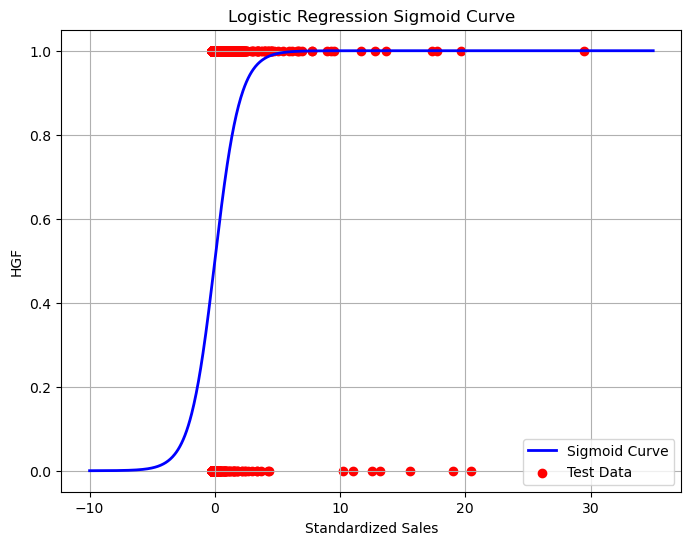

In [92]:
#Plot sigmoid diagram
# Generate a range of values for X for plotting the sigmoid curve
X_range = np.linspace(-10, 35, 1000)  

# Calculate the predicted probabilities using the logistic function (sigmoid)
predicted_probabilities = 1 / (1 + np.exp(-X_range))

# Plot the sigmoid curve
plt.figure(figsize=(8, 6))
plt.plot(X_range, predicted_probabilities,color='blue', linewidth=2, label='Sigmoid Curve')  # Use [:, 1] to get probabilities for class 1
plt.scatter(X_test['sales'], y_test, color='red', label='Test Data', marker='o')

plt.xlabel('Standardized Sales')
plt.ylabel('HGF')
plt.title('Logistic Regression Sigmoid Curve')
plt.legend()
plt.grid(True)
plt.show()

## 1.2 Support Vector Machine SVM

In [114]:
from sklearn.svm import SVC

In [115]:
# Instantiate the model
#svm_classifier = SVC(kernel='rbf',class_weight='balanced', random_state=42)

In [116]:
from sklearn.utils import class_weight

# Calculate class weights manually
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

# Instantiate the model with manual class weights
svm_classifier = SVC(kernel='rbf', class_weight=class_weight_dict, random_state=42)

In [117]:
#Train the model
svm_classifier.fit(X_train, y_train)

SVC(class_weight={0: 5.148666735303202, 1: 0.5537788605282099}, random_state=42)

In [ ]:
#Make prediction
y_svm_train_pred = svm_classifier.predict(X_train)
y_svm_val_pred = svm_classifier.predict(X_val)
y_svm_test_pred = svm_classifier.predict(X_test)

In [99]:
# Print classification report
print(classification_report(y_test, y_log_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       817
           1       0.85      1.00      0.92      4475

    accuracy                           0.85      5292
   macro avg       0.42      0.50      0.46      5292
weighted avg       0.71      0.85      0.77      5292



## 1.3 K-Nearest Neighbour KNN 

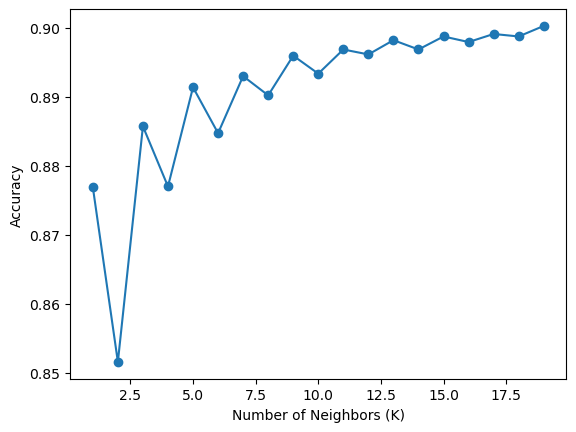

In [103]:
# Find the number of neighbour N with Elbow Method

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Initialize empty lists to store results
k_values = []
accuracy_values = []

# Test different values of K
for k in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    k_values.append(k)
    accuracy_values.append(accuracy)

# Plot the results
plt.plot(k_values, accuracy_values, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.show()

In [106]:
# From the elbow diagram above, I chose n = 5 as it offers the optimum accuracy 

# Initialize the KNN model with n = 5 
knn_model = KNeighborsClassifier(n_neighbors=5)

In [108]:
# Train the model
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [109]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test)

In [111]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [112]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 119  698]
 [ 132 4343]]


In [113]:
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.15      0.22       817
           1       0.86      0.97      0.91      4475

    accuracy                           0.84      5292
   macro avg       0.67      0.56      0.57      5292
weighted avg       0.80      0.84      0.81      5292

